<a href="https://colab.research.google.com/github/lakshitgosain/Tensorflow-ZTM/blob/main/TF_ZTM_05_TransferLearning_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Tensorflow Part 2: Fine Tuning



In [1]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2023-06-01 10:22:59--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-01 10:22:59 (102 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Let's get some data

This time we're going to see how we can use the pre-trained models within tf.keras.applications and apply them to our own problem



Get the 10% Foor dataset

In [2]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data('10_food_classes_10_percent.zip')

--2023-06-01 10:23:03--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.172.128, 209.85.200.128, 209.85.234.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.172.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   255MB/s    in 0.6s    

2023-06-01 10:23:03 (255 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [4]:
# Create training and test direcotry paths

train_dir="10_food_classes_10_percent/train"
test_dir="10_food_classes_10_percent/test"

In [5]:
import tensorflow as tf

IMG_SIZE=(224,224)
BATCH_SIZE=32
train_data_10_percent=tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    image_size=IMG_SIZE,
    label_mode='categorical',
    batch_size=BATCH_SIZE,

)

test_data=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                              image_size=IMG_SIZE,
                                                              label_mode='categorical',
                                                              batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [6]:
train_data_10_percent # NONE is insterted due to the batch sie

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [7]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [8]:
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[2.23229599e+02 1.86229599e+02 8.22295914e+01]
   [2.27816330e+02 1.90816330e+02 8.68163300e+01]
   [2.31607132e+02 1.93607132e+02 9.26071396e+01]
   ...
   [6.21326485e+01 2.38417950e+01 5.98976803e+00]
   [6.32602386e+01 2.16173820e+01 4.85206604e+00]
   [6.12141113e+01 1.95712547e+01 2.98453188e+00]]

  [[2.20500000e+02 1.83525497e+02 7.73775558e+01]
   [2.20214294e+02 1.83214294e+02 7.89336777e+01]
   [2.21770416e+02 1.83770416e+02 8.33112259e+01]
   ...
   [6.63571014e+01 2.94132233e+01 3.19893765e+00]
   [6.80765457e+01 2.81377678e+01 2.78571439e+00]
   [6.53365631e+01 2.34079933e+01 5.96906424e-01]]

  [[2.15132660e+02 1.78994904e+02 6.78367386e+01]
   [2.13642868e+02 1.76642868e+02 7.05714264e+01]
   [2.16091843e+02 1.77923462e+02 7.95969391e+01]
   ...
   [7.24439163e+01 3.48265762e+01 4.59137261e-02]
   [7.98724670e+01 4.06734467e+01 3.87243795e+00]
   [7.55713196e+01 3.37856064e+01 0.00000000e+00]]

  ...

  [[2.47362259e+02 2.40362259e+02 1.86010223e+02]
   [2

Keras Sequential vs FUnctional API

* Functional API is more flexible

## Model 0 : Building a transfer learning feature extraction model with Functional API

The sequential API is straight forward, but the functional API Gives us more flexibility with our models

In [9]:
#1. Create the base model with tf.keras.applications

base_model=tf.keras.applications.EfficientNetB0(
    include_top=False,

)

# 2. Freeze the base model(the underlying pre-trained patterns aren't modified )

base_model.trainable=False

#3. Create the input into our odel
inputs =  tf.keras.layers.Input(shape=(224,224,3), name='Input layer')

#4. If using Resnet50V2 you will need to normalize inputs
#x=tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

#5. pass the inputs to the base_model
x=base_model(inputs)
print(f"shape after passing inputs to our base model{x.shape}")

#6. Average pool the outputs of the base model(aggregate all the most importantinformation)
x=tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f"shape after global averagepooling2D:{x.shape}")

#7. Create the otput activation layer
outputs=tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

#8 Comibe the inputs with the outputs into a model
model_0=tf.keras.Model(inputs, outputs)

#9 Compile the model
model_0.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)
#10. Fit the model and save it's history
istory_10_percent= model_0.fit(train_data_10_percent,
                               epochs=5,
                               steps_per_epoch=len(train_data_10_percent),
                               validation_data=test_data,
                               validation_steps=int(0.25*len(test_data)),
                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                      experiment_name='10_percent')])




16705208/16705208 [==============================] - 0s 0us/step


shape after passing inputs to our base model(None, 7, 7, 1280)
shape after global averagepooling2D:(None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent/20230601-102313
Epoch 1/5
24/24 [==============================] - 36s 353ms/step - loss: 1.8828 - accuracy: 0.4227 - val_loss: 1.3204 - val_accuracy: 0.7385
Epoch 2/5
24/24 [==============================] - 6s 221ms/step - loss: 1.1007 - accuracy: 0.7640 - val_loss: 0.8530 - val_accuracy: 0.8438
Epoch 3/5
24/24 [==============================] - 5s 190ms/step - loss: 0.7802 - accuracy: 0.8213 - val_loss: 0.6892 - val_accuracy: 0.8635
Epoch 4/5
24/24 [==============================] - 6s 202ms/step - loss: 0.6320 - accuracy: 0.8627 - val_loss: 0.6162 - val_accuracy: 0.8717
Epoch 5/5
24/24 [==============================] - 6s 231ms/step - loss: 0.5375 - accuracy: 0.8867 - val_loss: 0.5539 - val_accuracy: 0.8766


In [10]:
model_0.evaluate(test_data)

79/79 [==============================] - 8s 90ms/step - loss: 0.5604 - accuracy: 0.8592


[0.5604402422904968, 0.8592000007629395]

In [11]:
#Check the layers in out base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer)

0 <keras.engine.input_layer.InputLayer object at 0x7fa385a967a0>
1 <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fa386183f70>
2 <keras.layers.preprocessing.normalization.Normalization object at 0x7fa385988250>
3 <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fa411dea860>
4 <keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7fa385988dc0>
5 <keras.layers.convolutional.conv2d.Conv2D object at 0x7fa385988fd0>
6 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fa38598aa70>
7 <keras.layers.core.activation.Activation object at 0x7fa38598b3d0>
8 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7fa38598bd00>
9 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fa385a24f70>
10 <keras.layers.core.activation.Activation object at 0x7fa385a25fc0>
11 <keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7fa385a26980>
12 <keras.l

In [12]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [13]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

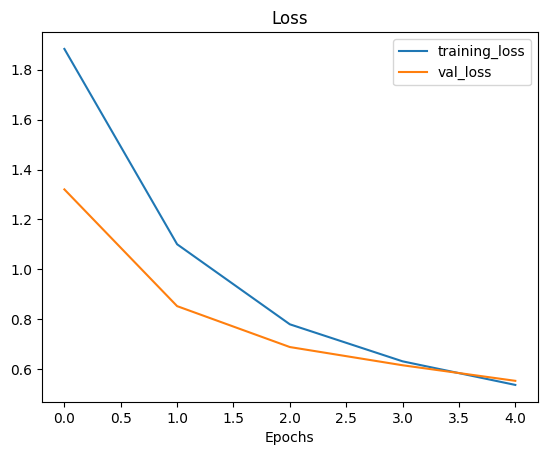

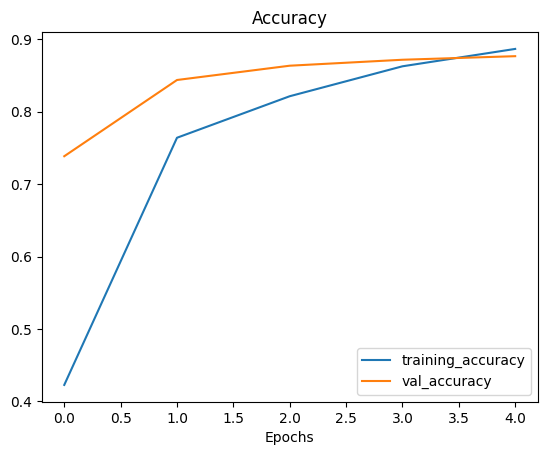

In [14]:
plot_loss_curves(istory_10_percent)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer.

We have a ensor after our model goes through 'base model' of shape (None, 7,7 , 1280).

But then it passes through GlobalAveragePooling2D, it turns into (None,1280).

let's use a similar shaped tensor (1,4,4,2) and the pass it through GlobalAverage2D.


In [15]:
input_shape=(1,4,4,3)

#Create a Random Tensor
tf.random.set_seed(42)
input_tensor=tf.random.normal(input_shape)

print("Random Input Tensor {}".format(input_tensor))



Random Input Tensor [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]


In [16]:
global_average_pooled_tensor=tf.keras.layers.GlobalAveragePooling2D()(input_tensor)

In [17]:
print(global_average_pooled_tensor)

tf.Tensor([[-0.09368646 -0.45840448 -0.2885598 ]], shape=(1, 3), dtype=float32)


In [18]:
print(f"Shape of input tensor{input_tensor.shape} and shapeof averagePooled Tensor{global_average_pooled_tensor.shape}")

Shape of input tensor(1, 4, 4, 3) and shapeof averagePooled Tensor(1, 3)


This is the input to the Output layer

One of the reasons feature extraction transfer learning is named how it is is because what happens is pretrained model outputs a feature vector (a long tensor of numbers which represents the learned representation of the model on a particular sample , in our case this is the output of tf.keras.layers.GlobalAveragePooling2D layer which can be then used to extract patterns out of for our own specific problem)

## Running a series of transfer learning experiments

We've seen the incredible results Transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data...how about we setup a bunch of experiments to find out

1. 'model_1' - use feature extraction transfer learning with 1% of the training data with data augmentation.
2. 'mode_2' - use feature extraction transfer learning with 10& of the training data with data aith data augmentation

3. 'model_3' - use fine tuning transfer learning with 10% of the training data with Data Augmentation

4. 'model_4'- use fin-tuning transfer learning on 100% of the training data with data augmentation.



## Getting and preprocessing data for model_1

In [20]:
# Download and unzip data 

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

--2023-06-01 10:37:10--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.120.128, 142.250.159.128, 142.251.120.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.120.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   136MB/s    in 0.9s    

2023-06-01 10:37:11 (136 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [21]:
unzip_data("10_food_classes_1_percent.zip")

In [27]:
train_dir_1_percent="10_food_classes_1_percent/train"
test_dir="10_food_classes_1_percent/test"

In [28]:
#How many images we are working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There a

In [29]:
IMG_SIZE=(224,224)
BATCH_SIZE=32
train_data_1_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                               image_size=IMG_SIZE,
                                                                               batch_size=BATCH_SIZE,
                                                                               label_mode='categorical')

test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              image_size=IMG_SIZE,
                                                              batch_size=BATCH_SIZE,
                                                              label_mode='categorical')

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.
